In [174]:
import pymysql
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import datetime

# 打开数据库连接
conn = pymysql.connect(host='192.168.16.50', port=3000, user='root', passwd='BigData2017!',\
                       db='hospital_dmp',charset="utf8")


In [53]:
buydate = pd.read_sql("select buy_date from hospital_dmp.orderlist_clean where buy_date >= \
unix_timestamp('2016-01-01') and buy_date <= unix_timestamp('2018-04-10');",conn)
buydate.head()

,buy_date
0,1452096000
1,1452096000
2,1451577600
3,1452009600
4,1451836800


In [18]:
df.keys()

Index(['shop_no', 'chain', 'buy_date', 'num', 'tip_no', 'member_no', 'price',
       'yspm', 'pzwh', 'pm', 'CJ', 'prodcode', 'PRODNAME', 'sort1', 'sort2',
       'otc_rx', 'zx', 'tym', 'jx', 'dx', 'match_rate', 'desc', 'clean_flag',
       'datetime'],
      dtype='object')

In [10]:
df = pd.read_sql("select * from hospital_dmp.orderlist_clean limit 1;",conn)
df.head()

,shop_no,chain,buy_date,num,tip_no,member_no,price,yspm,pzwh,pm,...,sort2,otc_rx,zx,tym,jx,dx,match_rate,desc,clean_flag,datetime
0,,10006,1452096000,1.0,c7c762ae1c35e8916d3682bd9b89f2ca,None,69.0,碧生源牌减肥茶,国食健字G20040371,常菁茶,...,None,其它,保健品,常菁茶,其它,成人,None,关联批准文号得出,1,2016-01-07


In [59]:
# 会员购买xb的总消费次数
sql_string = "select member_no,count(distinct tip_no) as total_consumption_amount_xb from hospital_dmp.orderlist_clean where buy_date>=1451577600 \
and buy_date<=1523289600 and CJ='北京九龙制药有限公司' and pm='小柴胡颗粒' and \
member_no in (select distinct member_no from hospital_dmp.orderlist_clean where CJ='北京九龙制药有限公司' and pm='小柴胡颗粒') \
group by member_no;"
df = pd.read_sql(sql_string,conn)
pickle.dump(df,open('total_consumption_amount_xb.pkl','wb+'))
df.head()

,member_no,total_consumption_amount_xb
0,000404d258666f2b258b3a4a02520ae3,1
1,000ee1fe7a0879a76badc076bab05220,2
2,00208be0d6dc313d4eb4f61bc48060c9,1
3,0026e3b5c421f4987becac0ef7652a64,1
4,0027ac5088d9ed1a596c9e096e2f55f3,2


In [69]:
# 会员购买同类适应症药品的总消费次数(包括xb)
sql_string = "select member_no,count(distinct tip_no) as total_patulin_consumption from hospital_dmp.orderlist_clean where \
buy_date>=1451577600 and buy_date<=1523289600 and tym='小柴胡' and member_no in (select distinct member_no from \
hospital_dmp.orderlist_clean where CJ='北京九龙制药有限公司' and pm='小柴胡颗粒') group by member_no;"
df = pd.read_sql(sql_string,conn)
pickle.dump(df,open('total_patulin_consumption.pkl','wb+'))
df.head()

,member_no,total_patulin_consumption
0,000404d258666f2b258b3a4a02520ae3,1
1,000ee1fe7a0879a76badc076bab05220,2
2,00208be0d6dc313d4eb4f61bc48060c9,1
3,0026e3b5c421f4987becac0ef7652a64,1
4,0027ac5088d9ed1a596c9e096e2f55f3,2


In [73]:
# 会员购买xb的总盒数,存在0值，表示退货行为
sql_string = "select member_no,sum(num) as total_xb_amount from hospital_dmp.orderlist_clean where buy_date>=1451577600 \
and buy_date<=1523289600 and CJ='北京九龙制药有限公司' and pm='小柴胡颗粒' and \
member_no in (select distinct member_no from hospital_dmp.orderlist_clean where CJ='北京九龙制药有限公司' and pm='小柴胡颗粒') \
group by member_no;"
df = pd.read_sql(sql_string,conn)
pickle.dump(df,open('total_xb_amount.pkl','wb+'))
df.head()

In [138]:
# 会员购买xb的总消费金额
sql_string = "select member_no,sum(num*price) as total_money_spend_xb from hospital_dmp.orderlist_clean where buy_date>=1451577600 \
and buy_date<=1523289600 and CJ='北京九龙制药有限公司' and pm='小柴胡颗粒' and \
member_no in (select distinct member_no from hospital_dmp.orderlist_clean where CJ='北京九龙制药有限公司' and pm='小柴胡颗粒') \
group by member_no;"
df = pd.read_sql(sql_string,conn)
pickle.dump(df,open('total_money_spend_xb.pkl','wb+'))
df.head()

,member_no,total_money_spend_xb
0,000404d258666f2b258b3a4a02520ae3,12.5
1,000ee1fe7a0879a76badc076bab05220,45.0
2,00208be0d6dc313d4eb4f61bc48060c9,27.6
3,0026e3b5c421f4987becac0ef7652a64,10.0
4,0027ac5088d9ed1a596c9e096e2f55f3,44.0


In [144]:
# 会员最近一次购买xb的时间间隔
sql_string = "select member_no,max(buy_date) as last_buy_xb_date from hospital_dmp.orderlist_clean where buy_date>=1451577600 and \
buy_date<=1523289600 and CJ='北京九龙制药有限公司' and pm='小柴胡颗粒' and member_no in (select distinct member_no from hospital_dmp.orderlist_clean \
where CJ='北京九龙制药有限公司' and pm='小柴胡颗粒') group by member_no;"
# 将时间戳转为20180101的int格式
df = pd.read_sql(sql_string,conn)
def utcTrans(timeStamp):
	dateArray = datetime.datetime.utcfromtimestamp(int(timeStamp))
	return int(dateArray.strftime("%Y%m%d"))
df.last_buy_xb_date = df.last_buy_xb_date.map(utcTrans)
pickle.dump(df,open('last_buy_xb_date.pkl','wb+'))
df.head()

In [193]:
# 
sql_string = "select FROM_UNIXTIME(buy_date) as buydate, price from hospital_dmp.orderlist_clean where buy_date>=1451577600 and \
buy_date<=1523289600 and CJ='北京九龙制药有限公司' and pm='小柴胡颗粒' and chain='10006' and shop_no='7f5144f962efde75e0f7661e032166db'\
group by buy_date,price;"
# 将时间戳转为20180101的int格式
df = pd.read_sql(sql_string,conn)
df.head()

,buydate,price
0,2016-07-04,8.0
1,2016-07-05,8.0
2,2016-07-09,13.5
3,2016-07-25,13.5
4,2016-08-27,13.5


In [194]:
df

,buydate,price
0,2016-07-04,8.00
1,2016-07-05,8.00
2,2016-07-09,13.50
3,2016-07-25,13.50
4,2016-08-27,13.50
5,2016-08-28,13.00
6,2016-09-21,13.50
7,2016-09-22,13.50
8,2016-11-16,13.50
9,2016-11-29,13.50


In [150]:
def calLastBuyToEndDays(last_buy_date):
    '''计算客户最近一次消费距观测窗口结束的天数观测窗口为20180410'''
    last_buy_date_str = str(last_buy_date)
    d1 = datetime.datetime(2018,4,10)
    d2 = datetime.datetime(int(last_buy_date_str[0:4]),int(last_buy_date_str[4:6]),int(last_buy_date_str[6:]))
    return (d1-d2).days

In [155]:
data_frame = pd.DataFrame(columns=['member_no','total_consumption_amount_xb','total_patulin_consumption','total_xb_amount',\
                                   'last_jz_date_interval','total_money_spend_xb'])
data_frame.member_no = pickle.load(open('total_consumption_amount_xb.pkl','rb+')).member_no
data_frame.total_consumption_amount_xb = pickle.load(open('total_consumption_amount_xb.pkl','rb+')).total_consumption_amount_xb
data_frame.total_patulin_consumption = pickle.load(open('total_patulin_consumption.pkl','rb+')).total_patulin_consumption 
data_frame.total_xb_amount = pickle.load(open('total_xb_amount.pkl','rb+')).total_xb_amount
data_frame.last_jz_date_interval = pickle.load(open('last_buy_xb_date.pkl','rb+')).last_buy_xb_date
data_frame.total_money_spend_xb = pickle.load(open('total_money_spend_xb.pkl','rb+')).total_money_spend_xb
data_frame.last_jz_date_interval = data_frame.last_jz_date_interval.map(calLastBuyToEndDays)

In [159]:
data_frame.head()

,member_no,total_consumption_amount_xb,total_patulin_consumption,total_xb_amount,last_jz_date_interval,total_money_spend_xb
0,000404d258666f2b258b3a4a02520ae3,1,1,1.0,771,12.5
1,000ee1fe7a0879a76badc076bab05220,2,2,3.0,688,45.0
2,00208be0d6dc313d4eb4f61bc48060c9,1,1,2.0,597,27.6
3,0026e3b5c421f4987becac0ef7652a64,1,1,1.0,621,10.0
4,0027ac5088d9ed1a596c9e096e2f55f3,2,2,3.0,670,44.0


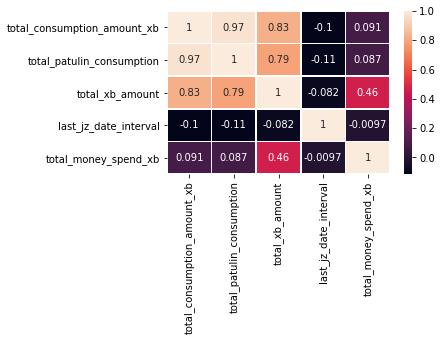

In [157]:
internal_chars = ['total_consumption_amount_xb','total_patulin_consumption','total_xb_amount',\
                                   'last_jz_date_interval','total_money_spend_xb']
corrmat = data_frame[internal_chars].corr()
f, ax = plt.subplots(figsize=(5, 3))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

In [161]:
data_frame_1 = pd.DataFrame(columns=['member_no','xbTopatulin','total_xb_amount',\
                                   'last_jz_date_interval','total_money_spend_xb'])
data_frame_1.member_no = pickle.load(open('total_consumption_amount_xb.pkl','rb+')).member_no
data_frame_1.xbTopatulin = pickle.load(open('total_consumption_amount_xb.pkl','rb+')).total_consumption_amount_xb / \
                             pickle.load(open('total_patulin_consumption.pkl','rb+')).total_patulin_consumption 
data_frame_1.total_xb_amount = pickle.load(open('total_xb_amount.pkl','rb+')).total_xb_amount
data_frame_1.last_jz_date_interval = pickle.load(open('last_buy_xb_date.pkl','rb+')).last_buy_xb_date
data_frame_1.total_money_spend_xb = pickle.load(open('total_money_spend_xb.pkl','rb+')).total_money_spend_xb
data_frame_1.last_jz_date_interval = data_frame_1.last_jz_date_interval.map(calLastBuyToEndDays)

In [162]:
data_frame_1.head()

,member_no,xbTopatulin,total_xb_amount,last_jz_date_interval,total_money_spend_xb
0,000404d258666f2b258b3a4a02520ae3,1.0,1.0,771,12.5
1,000ee1fe7a0879a76badc076bab05220,1.0,3.0,688,45.0
2,00208be0d6dc313d4eb4f61bc48060c9,1.0,2.0,597,27.6
3,0026e3b5c421f4987becac0ef7652a64,1.0,1.0,621,10.0
4,0027ac5088d9ed1a596c9e096e2f55f3,1.0,3.0,670,44.0


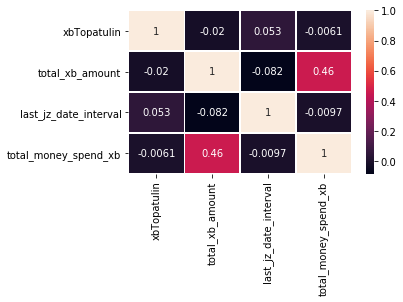

In [164]:
internal_chars = ['xbTopatulin','total_xb_amount',\
                                   'last_jz_date_interval','total_money_spend_xb']
corrmat = data_frame_1[internal_chars].corr()
f, ax = plt.subplots(figsize=(5, 3))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000607D6B00>,
      dtype=object)

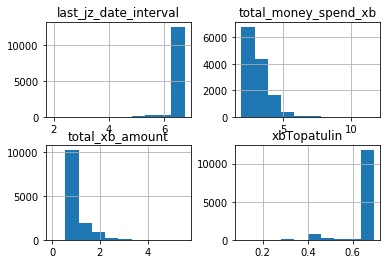

In [169]:
data_frame_1_no_id = data_frame_1.drop(['member_no'],axis=1)
data_frame_1_no_id = np.log(data_frame_1_no_id+1)
data_frame_1_no_id.hist()

In [92]:
loyalty = pd.DataFrame({'member_no':data_frame.member_no,\
                        'loyalty_score':np.log(data_frame.total_consumption_amount_xb*data_frame.total_xb_amount/data_frame.total_patulin_consumption+1)},\
                       columns=['member_no','loyalty_score'])
pickle.dump(loyalty,open('xb_loyalty_score.pkl','wb+'))

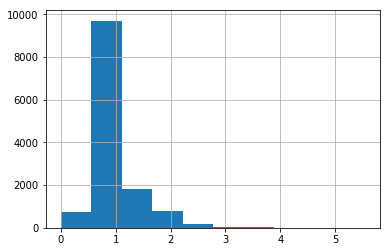

In [115]:
loyalty.loyalty_score.hist()

In [131]:
loyalty_1 = pd.DataFrame({'member_no':data_frame.member_no,\
                        'a':data_frame.total_consumption_amount_xb/data_frame.total_patulin_consumption,\
                         'b':data_frame.total_xb_amount},\
                       columns=['member_no','a','b'])

In [132]:
loyalty_1_no_id = loyalty_1.drop(['member_no'],axis=1)
loyalty_1_no_id = np.log(loyalty_1_no_id+1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000649B3630>,
      dtype=object)

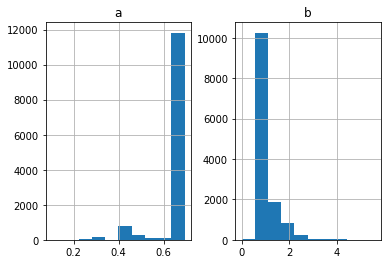

In [133]:
loyalty_1_no_id.hist()

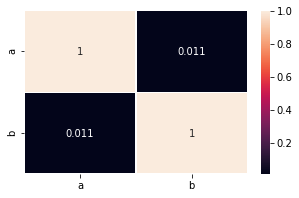

In [135]:
internal_chars = ['a','b']
corrmat = loyalty_1_no_id[internal_chars].corr()
f, ax = plt.subplots(figsize=(5, 3))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

In [113]:
def kmeans_model(feature_df,n,isPlot=False):            
    # K-means对标准化后的loyalty_no_id_drop_n进行聚类
    np.random.seed(42)
    data = np.array(feature_df)
    n_samples, n_features = data.shape
    n_digits = n
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, max_iter=1000, n_init=10)
    kmeans.fit(reduced_data)
    if isPlot:
        # Step size of the mesh. Decrease to increase the quality of the VQ.
        h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

        # Plot the decision boundary. For that, we will assign a color to each
        x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
        y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(4)
        plt.clf()
        plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.Paired,
                   aspect='auto', origin='lower')

        plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
        # Plot the centroids as a white X
        centroids = kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=169, linewidths=3,
                    color='w', zorder=10)
        plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
                  'Centroids are marked with white cross')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        plt.show()
    return kmeans.labels_

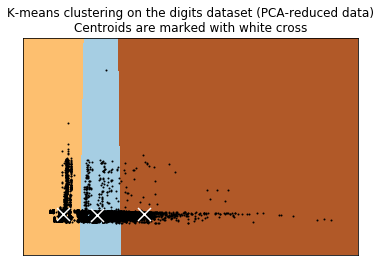

In [170]:
labels_loyalty = kmeans_model(data_frame_1_no_id,n=3,isPlot=True)

number of estimated clusters : 28


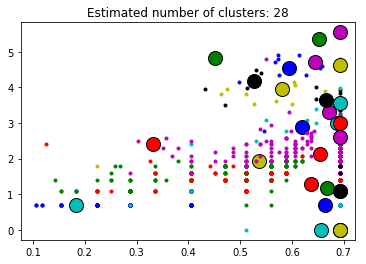

In [171]:
# MeanShfit均值漂移算法对标准化后的loyalty_no_id_drop_n进行聚类
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = np.array(data_frame_1_no_id)

# bandwidth估计加权核的带宽
# n_samples参数指定用于估计的样本数
# quantile指定至少被使用的指定数量样本数的分位数。（取值与[0, 1]）
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=10000, random_state=42, n_jobs=2) 

# bin_seeding用来设定初始核的位置参数的生成方式，default False,默认采用所有点的
# 位置平均，当改为True时使用离散后的点的平均，前者比后者慢。
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

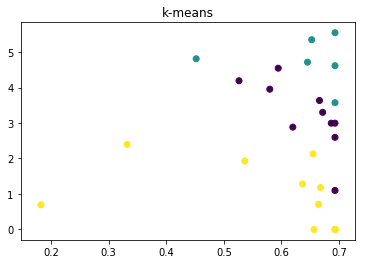

In [172]:
# K-means对标准化后的loyalty_no_id_drop_n进行聚类（2）
np.random.seed(42)

data = cluster_centers

n_samples, n_features = data.shape
n_digits = 3

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, max_iter=1000, n_init=10)
y_pred = kmeans.fit_predict(reduced_data)

plt.title('k-means')
plt.scatter(data[:, 0], data[:, 1], c=y_pred)
plt.show()